In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten,Conv2D,Dropout
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy,mean_squared_error,mean_absolute_error
from tensorflow.keras.metrics import Accuracy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report
lenc = LabelEncoder()
ohe = OneHotEncoder()

In [2]:
N_CLASSES = 5
IMSIZE = (128,128,3)
INPUT_SIZE = 1000

In [3]:
def finetuned_resnet(include_top=False):
    base_model = ResNet50(include_top=include_top,input_shape=IMSIZE)
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(1024, activation='relu')(x)

    if not include_top:
        x = Dense(N_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=Adam(),loss=BinaryCrossentropy(from_logits=False),metrics=Accuracy())

    return model

In [4]:
resnet_model = finetuned_resnet()

2022-05-21 14:42:58.495149: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-21 14:42:58.495214: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (devil): /proc/driver/nvidia/version does not exist
2022-05-21 14:42:58.496017: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
Data = pd.read_csv("gestures.csv")

In [6]:
X,Y = np.array(Data.drop(columns="classes")).reshape(-1,128,128,3), ohe.fit_transform(np.array(Data.classes).reshape(-1,1)).toarray()
xtrain,xtest,ytrain,ytest = train_test_split(X,Y,train_size=0.8)
del Data

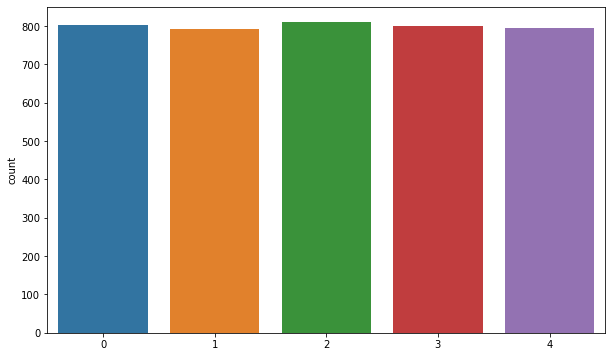

In [16]:
y = ohe.inverse_transform(ytrain)

plt.figure("countplot",figsize=(10,6))
sns.countplot(x=y.flatten())
plt.show()

In [17]:
resnet_model.fit(xtrain,ytrain,epochs=20,validation_split=0.2,batch_size=20)

Epoch 1/20


2022-05-21 14:48:32.253238: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1258291200 exceeds 10% of free system memory.


160/160 [==============================] - 69s 417ms/step - loss: 0.2639 - accuracy: 0.0000e+00 - val_loss: 0.1209 - val_accuracy: 0.0000e+00
Epoch 2/20
160/160 [==============================] - 67s 421ms/step - loss: 0.1103 - accuracy: 3.1250e-04 - val_loss: 0.0688 - val_accuracy: 2.5000e-04
Epoch 3/20
160/160 [==============================] - 63s 392ms/step - loss: 0.0901 - accuracy: 0.0016 - val_loss: 0.0529 - val_accuracy: 7.5000e-04
Epoch 4/20
160/160 [==============================] - 60s 374ms/step - loss: 0.0681 - accuracy: 0.0058 - val_loss: 0.0528 - val_accuracy: 0.0075
Epoch 5/20
160/160 [==============================] - 63s 394ms/step - loss: 0.0618 - accuracy: 0.0104 - val_loss: 0.0507 - val_accuracy: 0.0077
Epoch 6/20
160/160 [==============================] - 64s 402ms/step - loss: 0.0536 - accuracy: 0.0198 - val_loss: 0.0459 - val_accuracy: 0.0175
Epoch 7/20
160/160 [==============================] - 63s 394ms/step - loss: 0.0456 - accuracy: 0.0267 - val_loss: 0.0394

In [18]:
res = resnet_model.predict(xtest).round(1)

In [19]:
res_f = ohe.inverse_transform(res)
ytest_f = ohe.inverse_transform(ytest)

In [20]:
print(classification_report(res_f,ytest_f))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       202
           1       0.95      0.98      0.97       200
           2       0.99      0.99      0.99       189
           3       0.98      0.99      0.98       198
           4       1.00      0.97      0.98       211

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



: 